In [1]:
import cv2 ## for the webcam and computer vision
import numpy as np 
from playsound import playsound ## alert sound
from PIL import Image, ImageDraw
import face_recognition ## face recognition
from tensorflow import keras ## for loading in the model
import matplotlib.pyplot as plt

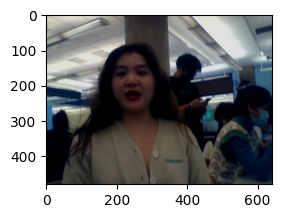

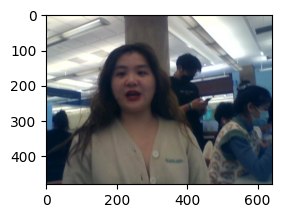

In [2]:
import cv2
import numpy as np

img1 = cv2.imread('open1.jpg')
img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
Intensity_matrix = np.ones(img1.shape,dtype = "uint8")*30
#print(Intensity_matrix)
Darken_img = cv2.subtract(img1,Intensity_matrix)
plt.subplot(1,2,1)
plt.imshow(Darken_img)
plt.show()
plt.subplot(1,2,2)
plt.imshow(img1)
plt.show()

In [3]:
eye_model = keras.models.load_model('Version3Eye.h5')
lip_model = keras.models.load_model('Version2_lip.h5')

In [4]:
def lip_cropper(frame):
    facial_features_list = face_recognition.face_landmarks(frame)
    lips = []
    try:
        lips.append(facial_features_list[0]['top_lip'])
        lips.append(facial_features_list[0]['bottom_lip'])
    except:
        return

    x_max1 = max([coordinate[0] for coordinate in lips[0]])
    y_max1 = max([coordinate[1] for coordinate in lips[0]])
    x_min2 = min([coordinate[0] for coordinate in lips[1]])
    y_min2 = min([coordinate[1] for coordinate in lips[1]])
    x_range = x_max1 - x_min2
    y_range = y_max1 - y_min2
    #print(lips[1])
    #print(lips)
    #print(x_max1,x_min1,y_max1,y_min1)
    #print(x_range,y_range)

    if x_range > y_range:
        right = int(round(.3*x_range) + x_max1)
        left = int(x_min2 - round(.3*x_range))
        bottom = int(round(((right-left) - y_range))/2 + y_max1)
        top = int(y_min2 - round(((right-left) - y_range))/2)
    else:
        bottom = int(round(.3*y_range) + y_max1)
        top = int(y_min2 - round(.3*y_range))
        right = int(round(((bottom-top) - x_range))/2 + x_max1)
        left = int(x_min2 - round(((bottom-top) - x_range))/2)

    #print(bottom,top,right,left)
    cropped = frame[top:(bottom + 1), left:(right + 1)]
    # resize the image

    #cropped = cv2.resize(cropped, (32,32))
    #image_for_prediction = cropped.reshape(-1, 32, 32, 3)
    image_for_prediction = cv2.resize(cropped, (80,80))


    return image_for_prediction



In [5]:
lip = cv2.imread('open1.jpg')
image_for_prediction = lip_cropper(lip)
plt.imshow(image_for_prediction)

In [6]:
def eye_cropper(frame):

    # create a variable for the facial feature coordinates

    facial_features_list = face_recognition.face_landmarks(frame)


    # create a placeholder list for the eye coordinates
    # and append coordinates for eyes to list unless eyes
    # weren't found by facial recognition

    try:
        eye = facial_features_list[0]['left_eye']
    except:
        try:
            eye = facial_features_list[0]['right_eye']
        except:
            return


    # establish the max x and y coordinates of the eye

    x_max = max([coordinate[0] for coordinate in eye])
    x_min = min([coordinate[0] for coordinate in eye])
    y_max = max([coordinate[1] for coordinate in eye])
    y_min = min([coordinate[1] for coordinate in eye])


    # establish the range of x and y coordinates

    x_range = x_max - x_min
    y_range = y_max - y_min


      # in order to make sure the full eye is captured,
      # calculate the coordinates of a square that has a
      # 50% cushion added to the axis with a larger range and
      # then match the smaller range to the cushioned larger range

    if x_range > y_range:
        right = round(.3*x_range) + x_max
        left = x_min - round(.3*x_range)
        bottom = round((((right-left) - y_range))/2) + y_max
        top = y_min - round((((right-left) - y_range))/2)
    else:
        bottom = round(.3*y_range) + y_max
        top = y_min - round(.3*y_range)
        right = round((((bottom-top) - x_range))/2) + x_max
        left = x_min - round((((bottom-top) - x_range))/2)


    # crop the image according to the coordinates determined above

    cropped = frame[top:(bottom + 1), left:(right + 1)]

    # resize the image

    #cropped = cv2.resize(cropped, (32,32))
    #image_for_prediction = cropped.reshape(-1, 32, 32, 3)
    image_for_prediction = cv2.resize(cropped, (80,80))


    return image_for_prediction

In [7]:
# # initiate webcam
# eye = 0
# lip = 0
# cap = cv2.VideoCapture(0)
# w = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
# h = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
# print(cap.get(cv2.CAP_PROP_FPS))


# if not cap.isOpened():
#     raise IOError('Cannot open webcam')

# # set a counter

# counter = 0

# # create a while loop that runs while webcam is in use

# while True:

#     # capture frames being outputted by webcam

#     ret, frame = cap.read()

#     # use only every other frame to manage speed and memory usage

#     frame_count = 0
#     if frame_count == 0:
#         frame_count += 1
#         pass
#     else:
#         count = 0
#         continue

#     # function called on the frame

#     try:
#         image_for_prediction = eye_cropper(frame)
#         image_for_prediction_lip = lip_cropper(frame)
#         image_for_prediction = np.array(image_for_prediction)
#         image_for_prediction = np.expand_dims(image_for_prediction, axis=0)
#         image_for_prediction_lip = np.array(image_for_prediction_lip)
#         image_for_prediction_lip = np.expand_dims(image_for_prediction_lip, axis=0)
#         prediction = eye_model.predict(image_for_prediction)
#         prediction_lip = lip_model.predict(image_for_prediction_lip)
#         prediction = np.argmax(prediction[0], axis=0)
#         prediction_lip = np.argmax(prediction_lip[0], axis=0)
#     except:
#         continue
    

#     if prediction == 1:
#         eye = eye + 1
#     else: 
#         eye = 0
#     if prediction_lip == 1:
#         lip = lip + 1
#     else: 
#         lip = 0
#     # Based on prediction, display either "Open Eyes" or "Closed Eyes"
#     try:
#         if lip <2 and eye < 5:
#             counter = 0
#             status = 'No_Yawn + Eye_Open'

#             #cv2.rectangle(frame, (round(w/2) - 110,20), (round(w/2) + 110, 80), (38,38,38), -1)

#             cv2.putText(frame, status, (round(w/2)-80,70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2, cv2.LINE_4)
#             x1, y1,w1,h1 = 0,0,175,75
#             ## Draw black backgroun rectangle
#             cv2.rectangle(frame, (x1,x1), (x1+w1-20, y1+h1-20), (0,0,0), -1)
#             ## Add text
#             cv2.putText(frame, 'Active', (x1 +int(w1/10), y1+int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255,0),2)
#         elif lip > 2 and eye > 5:
#             counter = counter + 1
#             status = 'Yawn + Eye_closed'

#             #cv2.rectangle(frame, (round(w/2) - 110,20), (round(w/2) + 110, 80), (38,38,38), -1)

#             cv2.putText(frame, status, (round(w/2)-104,70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2, cv2.LINE_4)
#             x1, y1,w1,h1 = 0,0,175,75
#             ## Draw black backgroun rectangle
#             cv2.rectangle(frame, (x1,x1), (x1+w1-20, y1+h1-20), (0,0,0), -1)
#             ## Add text
#             cv2.putText(frame, 'Active', (x1 +int(w1/10), y1+int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255,0),2)
#         elif lip < 2 and eye > 5:
#             counter = counter + 1
#             status = 'No_Yawn + Eye_closed'

#             #cv2.rectangle(frame, (round(w/2) - 110,20), (round(w/2) + 110, 80), (38,38,38), -1)

#             cv2.putText(frame, status, (round(w/2)-104,70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2, cv2.LINE_4)
#             x1, y1,w1,h1 = 0,0,175,75
#             ## Draw black backgroun rectangle
#             cv2.rectangle(frame, (x1,x1), (x1+w1-20, y1+h1-20), (0,0,0), -1)
#             ## Add text
#             cv2.putText(frame, 'Active', (x1 +int(w1/10), y1+int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255,0),2)

#             # if the counter is greater than 3, play and show alert that user is asleep
#         else: 
#             counter = counter + 1
#             status = 'Yawn + Eye_Open'

#             #cv2.rectangle(frame, (round(w/2) - 110,20), (round(w/2) + 110, 80), (38,38,38), -1)

#             cv2.putText(frame, status, (round(w/2)-104,70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2, cv2.LINE_4)
#             x1, y1,w1,h1 = 0,0,175,75
#             ## Draw black backgroun rectangle
#             cv2.rectangle(frame, (x1,x1), (x1+w1-20, y1+h1-20), (0,0,0), -1)
#             ## Add text
#             cv2.putText(frame, 'Active', (x1 +int(w1/10), y1+int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255,0),2)
#         if counter > 2:

#             x1, y1, w1, h1 = 400,400,400,100

#             cv2.rectangle(frame, (round(w/2) - 160, round(h) - 200), (round(w/2) + 160, round(h) - 120), (0,0,255), -1)

#             cv2.putText(frame, 'SLEEPING', (round(w/2)-136,round(h) - 146), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2, cv2.LINE_4)

#             cv2.imshow('Drowsiness Detection', frame)
#             k = cv2.waitKey(1)
#             ## Sound
#             #playsound('rooster.mov')
#             counter = 1
#     except:
#         continue
#     cv2.imshow('Drowsiness Detection', frame)
#     k = cv2.waitKey(1)
#     if k == 27:
#         break
# cap.release()
# cv2.destroyAllWindows()

In [15]:
BUFFER_AMOUNT = 20

def Drowsy_Studying():
    # initiate webcam
    eye = 0
    lip = 0
    cap = cv2.VideoCapture(0)
    w = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
    h = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
    print(cap.get(cv2.CAP_PROP_FPS))


    if not cap.isOpened():
        raise IOError('Cannot open webcam')

    # set a counter
    score = 0
    counter = 0
    rounds = 0

    # create a while loop that runs while webcam is in use

    while True:

        # capture frames being outputted by webcam
        
        ret, frame = cap.read()

        # use only every other frame to manage speed and memory usage

        frame_count = 0
        if frame_count == 0:
            frame_count += 1
            pass
        else:
            count = 0
            continue

        # function called on the frame
        try:
            image_for_prediction = eye_cropper(frame)
            image_for_prediction_lip = lip_cropper(frame)
            image_for_prediction = np.array(image_for_prediction)
            image_for_prediction = np.expand_dims(image_for_prediction, axis=0)
            image_for_prediction_lip = np.array(image_for_prediction_lip)
            image_for_prediction_lip = np.expand_dims(image_for_prediction_lip, axis=0)
            prediction = eye_model.predict(image_for_prediction)
            prediction_lip = lip_model.predict(image_for_prediction_lip)
            prediction = np.argmax(prediction[0], axis=0)
            prediction_lip = np.argmax(prediction_lip[0], axis=0)
        except:
            continue


        if prediction == 1:
            eye = eye + 1
        else: 
            eye = 0
        if prediction_lip == 0:
            lip = lip + 1
        else: 
            lip = 0
        # Based on prediction, display either "Open Eyes" or "Closed Eyes"
        try:
            if lip <2 and eye < 5:
                counter = 0
                status = 'No_Yawn + Eye_Open'
                score +=  3

                #cv2.rectangle(frame, (round(w/2) - 110,20), (round(w/2) + 110, 80), (38,38,38), -1)

                cv2.putText(frame, status, (round(w/2)-80,70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2, cv2.LINE_4)
                x1, y1,w1,h1 = 0,0,175,75
                ## Draw black backgroun rectangle
                cv2.rectangle(frame, (x1,x1), (x1+w1-20, y1+h1-20), (0,0,0), -1)
                ## Add text
                cv2.putText(frame, 'Active', (x1 +int(w1/10), y1+int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255,0),2)
            elif lip > 2 and eye > 5:
                counter = counter + 1
                status = 'Yawn + Eye_closed'
                score += 8

                #cv2.rectangle(frame, (round(w/2) - 110,20), (round(w/2) + 110, 80), (38,38,38), -1)

                cv2.putText(frame, status, (round(w/2)-104,70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2, cv2.LINE_4)
                x1, y1,w1,h1 = 0,0,175,75
                ## Draw black backgroun rectangle
                cv2.rectangle(frame, (x1,x1), (x1+w1-20, y1+h1-20), (0,0,0), -1)
                ## Add text
                cv2.putText(frame, 'Active', (x1 +int(w1/10), y1+int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255,0),2)
            elif lip < 2 and eye > 5:
                counter = counter + 1
                status = 'No_Yawn + Eye_closed'
                score += 5

                #cv2.rectangle(frame, (round(w/2) - 110,20), (round(w/2) + 110, 80), (38,38,38), -1)

                cv2.putText(frame, status, (round(w/2)-104,70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2, cv2.LINE_4)
                x1, y1,w1,h1 = 0,0,175,75
                ## Draw black backgroun rectangle
                cv2.rectangle(frame, (x1,x1), (x1+w1-20, y1+h1-20), (0,0,0), -1)
                ## Add text
                cv2.putText(frame, 'Active', (x1 +int(w1/10), y1+int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255,0),2)

                # if the counter is greater than 3, play and show alert that user is asleep
            else: 
                counter = counter + 1
                status = 'Yawn + Eye_Open'
                score += 6

                #cv2.rectangle(frame, (round(w/2) - 110,20), (round(w/2) + 110, 80), (38,38,38), -1)

                cv2.putText(frame, status, (round(w/2)-104,70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2, cv2.LINE_4)
                x1, y1,w1,h1 = 0,0,175,75
                ## Draw black backgroun rectangle
                cv2.rectangle(frame, (x1,x1), (x1+w1-20, y1+h1-20), (0,0,0), -1)
                ## Add text
                cv2.putText(frame, 'Active', (x1 +int(w1/10), y1+int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255,0),2)
            if counter > 2:

                x1, y1, w1, h1 = 400,400,400,100

                cv2.rectangle(frame, (round(w/2) - 160, round(h) - 200), (round(w/2) + 160, round(h) - 120), (0,0,255), -1)

                cv2.putText(frame, 'SLEEPING', (round(w/2)-136,round(h) - 146), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2, cv2.LINE_4)

                cv2.imshow('Drowsiness Detection', frame)
                k = cv2.waitKey(1)
                ## Sound
                #playsound('rooster.mov')
                counter = 1
        except:
            continue
        rounds +=1 
        if rounds > 20:
            print("Score is {0}".format(score), end=' \n')
            rounds = 0
            score = 0
            
        cv2.imshow('Drowsiness Detection', frame)
        #print(rounds)
        k = cv2.waitKey(1)
        if k == 27:
            break
    cap.release()
    cv2.destroyAllWindows()

In [17]:
Drowsy_Studying()

30.0
Score is 98 
Score is 84 
Score is 70 
Score is 74 


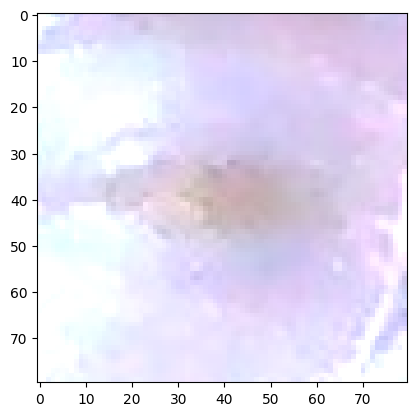

1


In [10]:
frame = cv2.imread("darkJG1.jpg")
#frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
image_for_prediction = eye_cropper(frame)
Intensity_matrix = np.ones(image_for_prediction.shape,dtype = "uint8")*130
image_for_prediction = cv2.add(image_for_prediction,Intensity_matrix)
#print(facial_features_list)
plt.imshow(image_for_prediction)
plt.show()
image_for_prediction = np.array(image_for_prediction)
image_for_prediction = np.expand_dims(image_for_prediction, axis=0)
prediction = eye_model.predict(image_for_prediction)
prediction = np.argmax(prediction[0], axis=0)
print(prediction)